# Loan Default Classification
## Cyrus Safaie
### Date: 12-08-2015



### Overview:

Loan status data set containing 67 variables and ~27K observations was originally provided in the University of Chicago Data Smackdown, data intensive contest in 2014. The variables come from 3 sources: Application data (Home ownership, loan purpose, address, etc.), Credit data (score, number of credit line, etc.) and loan specification data (interest rate, payment, etc.).

The intention is to create a predictive model to predict loan status (Defaulted or Fully Paid) based on 67 independent variables using various classification methods, and select the best model based on its performance on a test set   

Following algorithms will be explored: logistic regression, KNN, SVM, Trees, Ensemble method, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn import cross_validation
from sklearn import datasets, linear_model, preprocessing
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC

from pylab import rcParams
from scipy import stats

### Data Dictionary:

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [4]:
data_dictionary=pd.read_csv("DataDictionary.csv",nrows=70, index_col=False)
print_full(data_dictionary)


   Variable Category                   Variable Name  \
0   Application Data                              id   
1   Application Data                  home_ownership   
2   Application Data                         purpose   
3   Application Data                       addr_city   
4   Application Data                      addr_state   
5   Application Data                            term   
6   Application Data                      annual_inc   
7   Application Data                       emp_title   
8        Credit Data                        is_inc_v   
9        Credit Data                  acc_now_delinq   
10       Credit Data            acc_open_past_24mths   
11       Credit Data                  bc_open_to_buy   
12       Credit Data                percent_bc_gt_75   
13       Credit Data                         bc_util   
14       Credit Data                             dti   
15       Credit Data                     delinq_2yrs   
16       Credit Data                     delinq_

In [5]:
loan_data=pd.read_csv("training_copy.csv")

In [6]:
loan_data.shape

(27356, 70)

In [7]:
loan_data.shape

(27356, 70)

### Data Cleansing:

The data contains multiple column with many missing values. We will innitially exclude all columns with more than 40% misssing value and then we'll drop any rows with missing values (this will also simplify the data collection process as some variable may no longer be needed for collection).  Loan ID, City, State and Job title variables would also be  dropped due to high level of variation for a categorical variable. After dropping the columns and removing rows with NA values we will end up with a 16731 observation

In [8]:
print_full((loan_data.isnull().sum()/27356)>.4)


id                                False
home_ownership                    False
purpose                           False
addr_city                         False
addr_state                        False
term                              False
annual_inc                        False
emp_title                         False
is_inc_v                          False
acc_now_delinq                    False
acc_open_past_24mths              False
bc_open_to_buy                    False
percent_bc_gt_75                  False
bc_util                           False
dti                               False
delinq_2yrs                       False
delinq_amnt                       False
inq_last_6mths                    False
mths_since_last_delinq             True
mths_since_last_record             True
mths_since_recent_inq             False
mths_since_recent_revol_delinq     True
mths_since_recent_bc              False
mort_acc                          False
open_acc                          False


In [9]:
loan_data = loan_data.drop(['id','addr_city','emp_title','mths_since_last_delinq',
                            'mths_since_last_record','mths_since_recent_revol_delinq','mths_since_recent_bc_dlq',
                           'mths_since_last_major_derog','npv','addr_state'], axis=1)

In [10]:
loan_data.shape

(27356, 60)

In [11]:
loan_data = loan_data.dropna(inplace=False)

In [12]:
loan_data.shape

(16731, 60)

In [13]:
# 1 as dummy for Defaulted and 0 for Fully paid status
loan_data["loan_status"]=(loan_data["loan_status"] == 'Defaulted').astype(int)

In [14]:
dummied = pd.get_dummies(loan_data.home_ownership)
dummied.columns = ["home_ownership_%s" % val for val in dummied.columns]
loan_data = pd.concat([dummied,loan_data.drop("home_ownership", 1)], axis=1)

dummied = pd.get_dummies(loan_data.purpose)
dummied.columns = ["loan_data_%s" % val for val in dummied.columns]
loan_data = pd.concat([dummied,loan_data.drop("purpose", 1)], axis=1)

#dummied = pd.get_dummies(loan_data.addr_state)
#dummied.columns = ["addr_state_%s" % val for val in dummied.columns]
#loan_data = pd.concat([dummied,loan_data.drop("addr_state", 1)], axis=1)

dummied = pd.get_dummies(loan_data.term)
dummied.columns = ["term_%s" % val for val in dummied.columns]
loan_data = pd.concat([dummied,loan_data.drop("term", 1)], axis=1)

dummied = pd.get_dummies(loan_data.is_inc_v)
dummied.columns = ["is_inc_v_%s" % val for val in dummied.columns]
loan_data = pd.concat([dummied,loan_data.drop("is_inc_v", 1)], axis=1)

dummied = pd.get_dummies(loan_data.grade)
dummied.columns = ["grade_%s" % val for val in dummied.columns]
loan_data = pd.concat([dummied,loan_data.drop("grade", 1)], axis=1)

dummied = pd.get_dummies(loan_data.sub_grade)
dummied.columns = ["sub_grade_%s" % val for val in dummied.columns]
loan_data = pd.concat([dummied,loan_data.drop("sub_grade", 1)], axis=1)

dummied = pd.get_dummies(loan_data.emp_length)
dummied.columns = ["emp_length_%s" % val for val in dummied.columns]
loan_data = pd.concat([dummied,loan_data.drop("emp_length", 1)], axis=1)

In [15]:
loan_data.shape

(16731, 130)

In [16]:
loan_data.head(5)

,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_op_rev_tl,tot_coll_amt,int_rate,loan_amnt,installment,loan_status
0,0,0,0,0,0,1,0,0,0,0,...,117,5,27400,8,9,0,0.1114,7200,236.20,0
1,0,1,0,0,0,0,0,0,0,0,...,427,2,35100,6,17,0,0.1776,15000,378.95,0
2,0,0,0,0,0,0,0,0,1,0,...,140,14,6100,1,3,3639,0.1433,6000,206.03,0
7,0,0,0,0,0,0,1,0,0,0,...,169,4,28100,6,9,0,0.1922,2500,91.92,0
8,0,0,1,0,0,0,0,0,0,0,...,189,23,38318,2,4,0,0.1678,24000,593.63,0


After creating the dummy variables, our data contain 129 varibales, 52 of which are quantitative and the remaining categorical. The quantitative variables have different units, and for some of the algorithms we are going to use scaled data is required. We store the output or depenent variabel "loan_status" in labels variable. Also all inputs/independent variables including categorical and scaled quantitative variables are store in X  

In [17]:
labels=np.asarray(loan_data["loan_status"])

quants = np.asarray(loan_data[loan_data.columns[77:129]]).astype(float)
quants = scale(quants, with_mean=True, with_std = True)

X = np.hstack((quants, np.asarray(loan_data[loan_data.columns[0:77]]).astype(float)))
labels.shape,X.shape

((16731,), (16731, 129))

In [18]:
sum(labels)

1758

Only 1758 loans have defaulted (~10%) from the 16731 observations that we are evaluating and we are trying to make the best prediction

Now we create a 70% traning and 30% random test split, which will be used for evaluating perfomance of all models on the data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, train_size = 0.7, random_state = 60134)

In [20]:
sum(y_train), sum(y_test)

(1243, 515)



### Model 1: Logistic Regression

Now that we have our data ready, we will start by fitting the simplest classificiation algorithm "Logistic Regression" to predict defaulted loans. All models will be fitted on te training set and accuracy metrics and errors (misclassification rate) will be reported based on the model performance on the test set (30% of the observations).

We will first fit the model with no regularization.

In [21]:
logit= LogisticRegression()
logit.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [22]:
test_preds = logit.predict(X_test)
pd.crosstab(index=y_test, columns=test_preds, rownames=['True'], colnames=['Predicted'])

Predicted,0,1
True,,
0,4493,12
1,512,3


In [23]:
logit_Score=accuracy_score(y_test, test_preds)
logit_Score

0.89561752988047805

Our very simple model logit has a an 89% accuracy in classification, but clearly it is not enough as it still classify most of the defaulted loans wrong. Very low recall for 1

In [24]:
print classification_report(y_test, test_preds, labels=[0,1])

             precision    recall  f1-score   support

          0       0.90      1.00      0.94      4505
          1       0.20      0.01      0.01       515

avg / total       0.83      0.90      0.85      5020



### Model 2: Logistic Regression - Regularized

In [25]:
logit_reg = LogisticRegression(C=1e5)
logit_reg.fit(X_train, y_train)

test_preds_probs = logit_reg.predict_proba(X_test)[:, 1]

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds_probs)

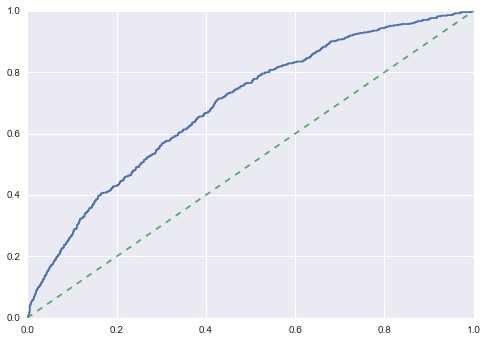

In [27]:
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

plt.plot(fpr, tpr)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.show()

In [28]:
roc_auc_score(y_test, test_preds_probs)

0.69045418790340829

In [29]:
test_preds2 = logit_reg.predict(X_test)
logit2_Score=accuracy_score(y_test, test_preds2)
logit2_Score

0.89561752988047805

Now we use param grid and cross validation to tune the parameters

In [36]:
param_grid = {'C':np.logspace(-5,5,3)}

In [37]:
param_grid

{'C': array([  1.00000000e-05,   1.00000000e+00,   1.00000000e+05])}

In [38]:
logit_reg2 = GridSearchCV(logit_reg, param_grid, cv = 2, n_jobs=1, refit = True)
logit_reg2.fit(X_train, y_train)

GridSearchCV(cv=2,
       estimator=LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.00000e+00,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

Since with any C and pentalty list the cv was taking a very long time, I am not running the possible vaue and just running a simple 2 fold CV and 3 values for C just for ** demonstration purposes **

In the context of default loan detection, identifying a loan that would be defaulted probably have more importance than correctly identifying the fully paid loans. The best way to deal with this phenomanom is to consider NPV of the loan as well as the risk tolerance of the portfolio, which both are important, but out of scope of this project. 

In [43]:
logit_reg2.best_estimator_

LogisticRegression(C=1.0000000000000001e-05, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=None, tol=0.0001)

In [44]:
logit_reg2.best_score_

0.89386047305951666

In [45]:
logit_reg2.grid_scores_

[mean: 0.89386, std: 0.00008, params: {'C': 1.0000000000000001e-05},
 mean: 0.89386, std: 0.00059, params: {'C': 1.0},
 mean: 0.89360, std: 0.00050, params: {'C': 100000.0}]

### Model 3: KNN

Now we use another powerfull algorithms K-Nearest Neighbors. We first start by fiiting a base model with assuming k=5 and then we will use CV for parameter tuning

In [21]:
neighbors = KNeighborsClassifier(n_neighbors = 5)
neighbors.fit(X_train,y_train)
K5_preds = neighbors.predict(X_test)


In [22]:
pd.crosstab(index=y_test, columns=K5_preds, rownames=['True'], colnames=['Predicted'])

Predicted,0,1
True,,
0,4455,50
1,505,10


In [23]:
K5_preds_probs = neighbors.predict_proba(X_test)[:,1]

In [24]:
k5_Score=accuracy_score(y_test, K5_preds)
k5_Score

0.8894422310756972

In [25]:
fpr_k5, tpr_k5, thresholds_k5 = roc_curve(y_test, K5_preds_probs)

In [ ]:
param_grid_knn = {'n_neighbors':[1,2,5,8,10,15,20,30]
              ##'weights':['uniform','distance'],
              ##'algorithm': ['kd_tree','ball_tree'],
              ##'metric':['manhattan','euclidean','chebyshev']
                 }
best_knn = GridSearchCV(neighbors, param_grid_knn,cv=2, refit = True)

best_knn.fit(X_train, y_train)